### Packages

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl
import pandas as pd

%matplotlib inline

### Load data and split into train/test sets

In [2]:
def load_signs_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

    classes = np.array(test_dataset["list_classes"][:]) # list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [4]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

X_train = X_train_orig/255.
X_test = X_test_orig/255.

Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


y = 5


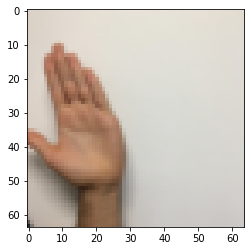

In [5]:
# Example of an image from the dataset
index = 300
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

### TF Keras Functional API

In [6]:
def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    We'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    input_img -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    input_img = tf.keras.Input(shape=input_shape)
    ## CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    ## RELU
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    ## RELU
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    ## FLATTEN
    ## Dense layer
    ## 6 neurons in output layer 
    # outputs

    Z1 = tfl.Conv2D(filters = 8,kernel_size = 4,strides=(1,1),padding='same')(input_img)
    A1 = tfl.ReLU()(Z1)
    P1 = tfl.MaxPool2D(pool_size=(8, 8), strides=(8, 8), padding='same')(A1)
    Z2 = tfl.Conv2D(filters = 16,kernel_size = 2,strides=(1,1),padding='same')(P1)
    A2 = tfl.ReLU()(Z2)
    P2 = tfl.MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding='same')(A2)
    F = tfl.Flatten()(P2)
    outputs = tfl.Dense(units=6, activation='softmax')(F)
    
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [7]:
conv_model = convolutional_model((64, 64, 3))
conv_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [8]:
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 8)         392       
                                                                 
 re_lu (ReLU)                (None, 64, 64, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          528       
                                                                 
 re_lu_1 (ReLU)              (None, 8, 8, 16)          0         
                                                             

### Train the Model

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
17/17 [==============================] - 1s 35ms/step - loss: 1.8020 - accuracy: 0.1509 - val_loss: 1.7878 - val_accuracy: 0.1917
Epoch 2/100
17/17 [==============================] - 0s 27ms/step - loss: 1.7899 - accuracy: 0.1880 - val_loss: 1.7835 - val_accuracy: 0.2333
Epoch 3/100
17/17 [==============================] - 0s 27ms/step - loss: 1.7857 - accuracy: 0.1750 - val_loss: 1.7784 - val_accuracy: 0.2000
Epoch 4/100
17/17 [==============================] - 0s 26ms/step - loss: 1.7810 - accuracy: 0.1963 - val_loss: 1.7731 - val_accuracy: 0.2667
Epoch 5/100
17/17 [==============================] - 0s 27ms/step - loss: 1.7753 - accuracy: 0.2352 - val_loss: 1.7664 - val_accuracy: 0.3333
Epoch 6/100
17/17 [==============================] - 0s 27ms/step - loss: 1.7684 - accuracy: 0.2444 - val_loss: 1.7586 - val_accuracy: 0.3667
Epoch 7/100
17/17 [==============================] - 0s 27ms/step - loss: 1.7604 - accuracy: 0.2806 - val_loss: 1.7498 - val_accuracy: 0.4333
Epoch 

17/17 [==============================] - 0s 25ms/step - loss: 0.6163 - accuracy: 0.8074 - val_loss: 0.6854 - val_accuracy: 0.7583
Epoch 59/100
17/17 [==============================] - 0s 25ms/step - loss: 0.6087 - accuracy: 0.8120 - val_loss: 0.6793 - val_accuracy: 0.7667
Epoch 60/100
17/17 [==============================] - 0s 25ms/step - loss: 0.6015 - accuracy: 0.8148 - val_loss: 0.6736 - val_accuracy: 0.7750
Epoch 61/100
17/17 [==============================] - 0s 25ms/step - loss: 0.5945 - accuracy: 0.8157 - val_loss: 0.6680 - val_accuracy: 0.7833
Epoch 62/100
17/17 [==============================] - 0s 25ms/step - loss: 0.5876 - accuracy: 0.8167 - val_loss: 0.6628 - val_accuracy: 0.7833
Epoch 63/100
17/17 [==============================] - 0s 26ms/step - loss: 0.5809 - accuracy: 0.8204 - val_loss: 0.6578 - val_accuracy: 0.7833
Epoch 64/100
17/17 [==============================] - 0s 26ms/step - loss: 0.5743 - accuracy: 0.8222 - val_loss: 0.6527 - val_accuracy: 0.7833
Epoch 65/100

<a name='5'></a>
###  History Object 

The history object is an output of the `.fit()` operation, and provides a record of all the loss and metric values in memory. It's stored as a dictionary that we can retrieve at `history.history`: 

In [10]:
history.history

{'loss': [1.802048921585083,
  1.7899104356765747,
  1.7856831550598145,
  1.7810392379760742,
  1.7752577066421509,
  1.7683815956115723,
  1.760392665863037,
  1.7503498792648315,
  1.7381455898284912,
  1.7227240800857544,
  1.704356074333191,
  1.679810881614685,
  1.6509524583816528,
  1.6189454793930054,
  1.5840314626693726,
  1.546631097793579,
  1.5083662271499634,
  1.468389630317688,
  1.428702712059021,
  1.3883142471313477,
  1.3468396663665771,
  1.3073673248291016,
  1.2680485248565674,
  1.2297860383987427,
  1.1913179159164429,
  1.1553856134414673,
  1.1220839023590088,
  1.0908805131912231,
  1.061148762702942,
  1.0315766334533691,
  1.004238486289978,
  0.9792861342430115,
  0.9554961323738098,
  0.9330600500106812,
  0.9119749665260315,
  0.8919929265975952,
  0.8733800053596497,
  0.8556510806083679,
  0.8388630747795105,
  0.8229633569717407,
  0.8078951835632324,
  0.7934034466743469,
  0.7784507274627686,
  0.7606179714202881,
  0.7480595111846924,
  0.7353616

C:\Users\sauja\AppData\Local\Temp/ipykernel_26800/973814028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
C:\Users\sauja\AppData\Local\Temp/ipykernel_26800/973814028.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

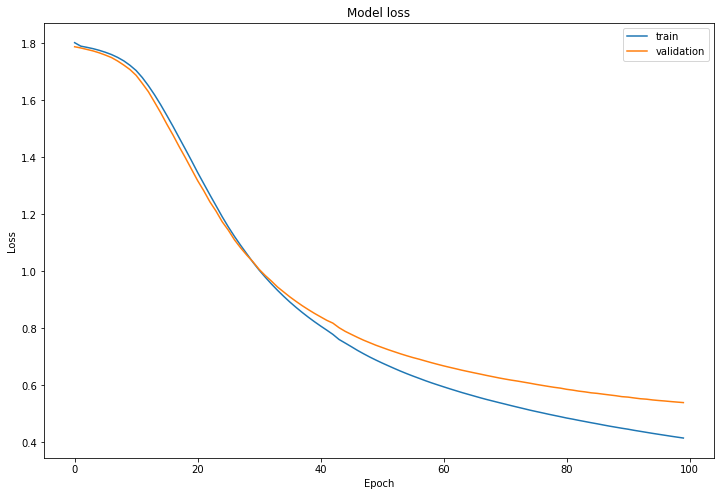

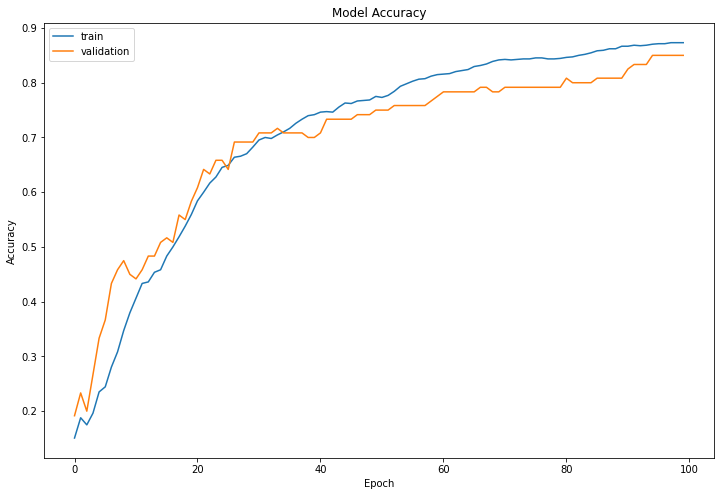

In [11]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')